<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

# Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph).
To know the basics of graph https://algs4.cs.princeton.edu/42digraph/

We want to know that given two nodes there should be a connection/vertices between them

# Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

# Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

# Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

# Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

# Importing libraries and Reading Data

In [130]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import os 
#!pip install networkx
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
import pdb
import pickle

In [2]:
os.chdir("D:\\Projects\\Machine-Learning\\Facebook")

In [3]:
os.path

<module 'ntpath' from 'C:\\Users\\aksha\\anaconda3\\lib\\ntpath.py'>

In [4]:
train_woheader = pd.read_csv("train_woheader.csv" , header = None)

In [5]:
train_woheader.shape

(9437519, 2)

In [6]:
train_woheader.head()

,0,1
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


Column **0** represent the **source node** and **1** represnt the **destination node**...we can see that data is arranged in such a way that for every connection for node 1 is alinged first then for node 2 and so on

directed graph means... for row 0 there is an edge between 1 and 690569 in the direction of 690569

In [7]:
g= nx.read_edgelist("train_woheader.csv",delimiter=',',create_using=nx.DiGraph(),nodetype=int)
#https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.readwrite.edgelist.read_edgelist.html

In [8]:
type(g)

networkx.classes.digraph.DiGraph

In [9]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


No of users/node = around 1.8M
For a single node average no of followers is 5, and that node follows 5 other person in general

**In-degree** = in_degree is the number of edges pointing to the node. The weighted node degree is the sum of the edge weights for edges incident to that node.
https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.DiGraph.in_degree.html?highlight=indegree

**Out-degree** = The node out_degree is the number of edges pointing out of the node. The weighted node degree is the sum of the edge weights for edges incident to that node.
https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.DiGraph.out_degree.html?highlight=outdegree

A Graph is a non-linear data structure consisting of nodes and edges. The nodes are sometimes also referred to as vertices and the edges are lines or arcs that connect any two nodes in the graph
https://www.geeksforgeeks.org/graph-data-structure-and-algorithms/

 ## Displaying a sub graph

In [10]:
#pd.read_csv('train_woheader.csv', nrows=50).to_csv('train_woheader_sample.csv',index=False)

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

Name: 
Type: DiGraph
Number of nodes: 67
Number of edges: 51
Average in degree:   0.7612
Average out degree:   0.7612


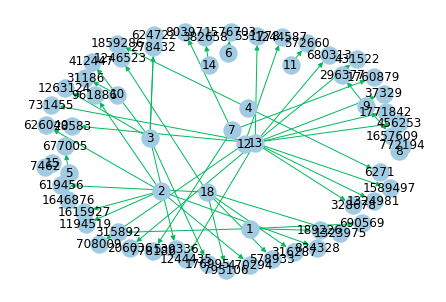

In [10]:
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlibabs
pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

**Plotting a sample of graph**

In [12]:
#if not os.path.isfile('train_woheader_sample.csv'):
#    pd.read_csv('data/train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
#subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

#pos=nx.spring_layout(subgraph)
#nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
#plt.savefig("graph_sample.pdf")
#print(nx.info(subgraph))

#  Exploratory Data Analysis

In [11]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))#as each node represent a user
#len function finds the len of the number of nodes contained in g

The number of unique persons 1862220


##  No of followers for each person

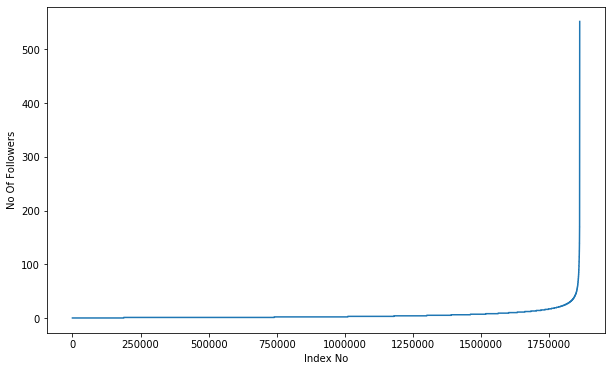

In [12]:
indegree_dist = list(dict(g.in_degree()).values())
#in_degree function in networkx 
#https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.DiGraph.in_degree.html
indegree_dist.sort() #sorting in ascending order so that the user with least no. of followers in plotted first
plt.figure(figsize=(10,6)) #figsize of 10ht and 6width
plt.plot(indegree_dist)
plt.xlabel('Index No') #label in the x-axis
plt.ylabel('No Of Followers') #label on y-axis
plt.show()

In [13]:
print(np.percentile(indegree_dist,99)) #calulating 99th percentile value of the no. of followers for each node
#what is a percentile
#https://en.wikipedia.org/wiki/Percentile

40.0


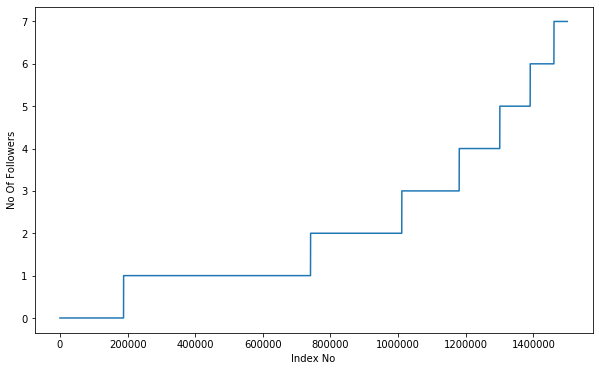

In [14]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000]) #taking values from 0 to 1.5M becuse in the above graph we saw that around 1.5M value the graph remains consistant
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

We can see that around **99%** of the people have **40 or less than 40 followers** and only few have more than 40followers which is shown in the graph **after 1750000 we can see step rise in the no of followers**

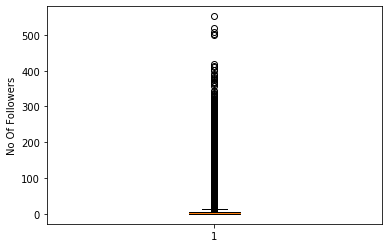

In [15]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

Can't get much information from this box plot

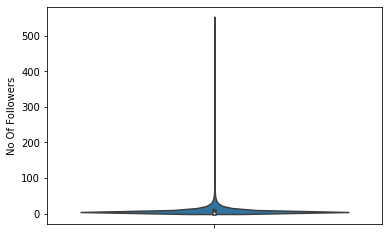

In [16]:
import seaborn as sns
sns.violinplot(y= indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

This plot solidifies our analysis that most of the users have less than 50 followers

In [17]:
### 90-100 percentile
for i in range(0,11):
    print(f"{90+i} percentile value is:{np.percentile(indegree_dist,90+i)}")

90 percentile value is:12.0
91 percentile value is:13.0
92 percentile value is:14.0
93 percentile value is:15.0
94 percentile value is:17.0
95 percentile value is:19.0
96 percentile value is:21.0
97 percentile value is:24.0
98 percentile value is:29.0
99 percentile value is:40.0
100 percentile value is:552.0


**99% of data having followers of 40 only.**

In [18]:
### 99-100 percentile
for i in range(10,110,10):
    print(f"{99+(i/100)} percentile value is : {np.percentile(indegree_dist,99+(i/100))}")

99.1 percentile value is : 42.0
99.2 percentile value is : 44.0
99.3 percentile value is : 47.0
99.4 percentile value is : 50.0
99.5 percentile value is : 55.0
99.6 percentile value is : 61.0
99.7 percentile value is : 70.0
99.8 percentile value is : 84.0
99.9 percentile value is : 112.0
100.0 percentile value is : 552.0


Around 99.8% of the user's have followers less than 100

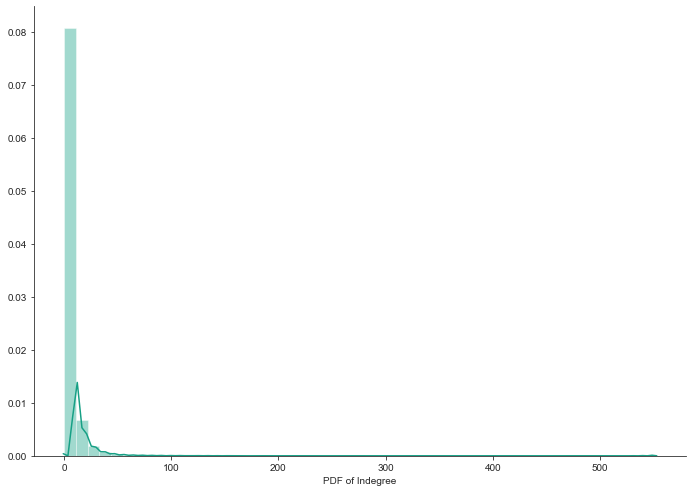

In [19]:
%matplotlib inline 
#magic command which lets plotting inside that notebook 
#https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline
sns.set_style('ticks') #https://seaborn.pydata.org/generated/seaborn.set_style.html
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085') #distribution plot if the in_degree , color value is the hex code
plt.xlabel('PDF of Indegree')
sns.despine() #despine function - #https://www.geeksforgeeks.org/seaborn-style-and-color/
#plt.show()

## No of people each person is following

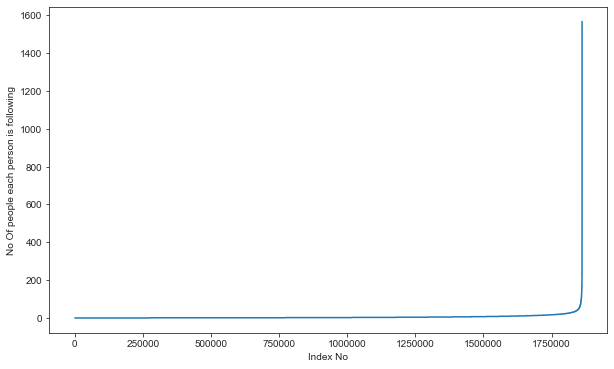

In [20]:
outdegree_dist = list(dict(g.out_degree()).values()) #finding the value of the no of out_degrees
outdegree_dist.sort()#sorting
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

In [21]:
print(np.percentile(outdegree_dist,99))#counting percentile value

40.0


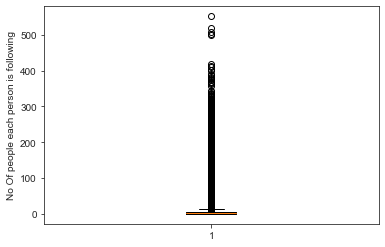

In [22]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

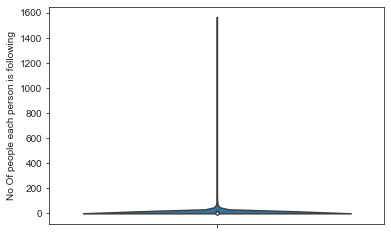

In [23]:
sns.violinplot(y=outdegree_dist)
plt.ylabel("No Of people each person is following")
plt.show()

In [24]:
### 90-100 percentile
for i in range(0,11):
    print(f"{90+i} percentile value is: {np.percentile(outdegree_dist,90+i)}")

90 percentile value is: 12.0
91 percentile value is: 13.0
92 percentile value is: 14.0
93 percentile value is: 15.0
94 percentile value is: 17.0
95 percentile value is: 19.0
96 percentile value is: 21.0
97 percentile value is: 24.0
98 percentile value is: 29.0
99 percentile value is: 40.0
100 percentile value is: 1566.0


In [25]:
### 99-100 percentile
for i in range(10,110,10):
    print(f"{99+(i/100)} percentile value is : {np.percentile(outdegree_dist,99+(i/100))}")

99.1 percentile value is : 42.0
99.2 percentile value is : 45.0
99.3 percentile value is : 48.0
99.4 percentile value is : 52.0
99.5 percentile value is : 56.0
99.6 percentile value is : 63.0
99.7 percentile value is : 73.0
99.8 percentile value is : 90.0
99.9 percentile value is : 123.0
100.0 percentile value is : 1566.0


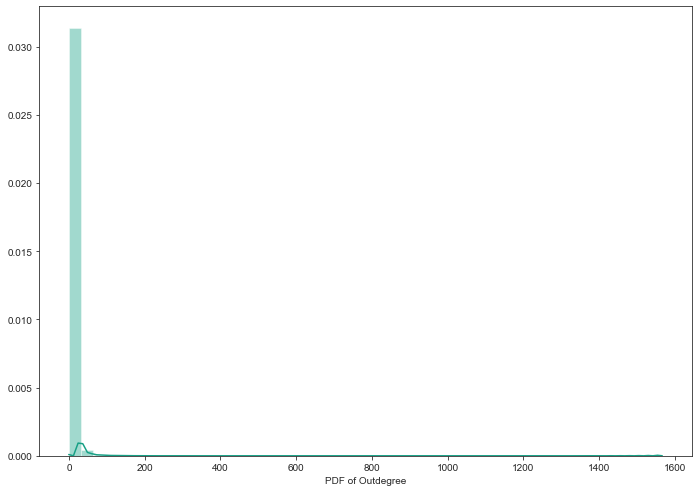

In [26]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
#sns.despine()
#if you want to see what the despine function does just uncomment the above code
plt.show()

In [27]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


We are storing all the values where outdegree_dist ==0 in an array and summing all the values of the number of times its 0 and for percentage we are just dividing it by total number of values in a outdegree_dist

In [28]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


We are storing all the values where indegree_dist ==0 in an array and summing all the values of the number of times its 0 and for percentage we are just dividing it by total number of values in a indegree_dist

In [29]:
count=0
for i in g.nodes(): #looping through all the nodes which are around 1.9M
    if len(list(g.predecessors(i)))==0 : #for a particular node checking the len of the 
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not following anyone and also not having any followers are',count)

No of persons those are not following anyone and also not having any followers are 0


A person will have 0 followers and 0 followees if the user doesnt have any predecessor or successor and that's we are iterating over each user(nodes) and checking if the len of the successor and predecessor is equal to 0 then we will increase the count by 1

**What are predecessors and sucessors in graph?**
http://pages.cs.wisc.edu/~vernon/cs367/notes/13.GRAPH.html

<img src=succ.gif>



The two nodes are adjacent (they are neighbors).

Node 2 is a **predecessor** of node 1.

Node 1 is a **successor** of node 2.

The source of the edge is node 2, and the target of the edge is node 1. 

## both followers + following 

In [30]:
from collections import Counter #https://www.geeksforgeeks.org/python-counter-objects-elements/
dict_in = dict(g.in_degree()) #creating a dictionary of all the in_degree
dict_out = dict(g.out_degree()) ##creating a dictionary of all the out_degree
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

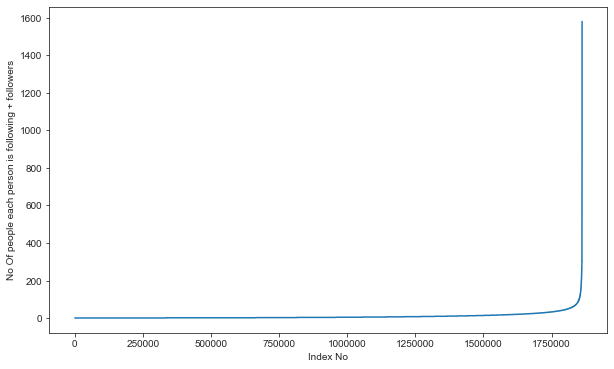

In [31]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

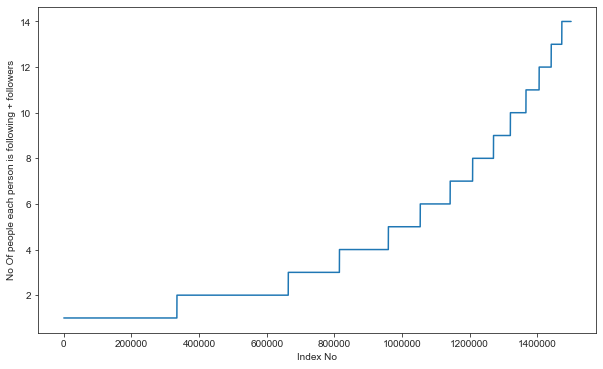

In [32]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [33]:
np.percentile(in_out_degree,99)

79.0

In [34]:
### 90-100 percentile
for i in range(0,11):
    print(f"{90+i} percentile value is :{np.percentile(in_out_degree_sort,90+i)}")

90 percentile value is :24.0
91 percentile value is :26.0
92 percentile value is :28.0
93 percentile value is :31.0
94 percentile value is :33.0
95 percentile value is :37.0
96 percentile value is :41.0
97 percentile value is :48.0
98 percentile value is :58.0
99 percentile value is :79.0
100 percentile value is :1579.0


In [35]:
### 99-100 percentile
for i in range(10,110,10):
    print(f"{99+(i/100)} percentile value is : {np.percentile(in_out_degree_sort,99+(i/100))}")

99.1 percentile value is : 83.0
99.2 percentile value is : 87.0
99.3 percentile value is : 93.0
99.4 percentile value is : 99.0
99.5 percentile value is : 108.0
99.6 percentile value is : 120.0
99.7 percentile value is : 138.0
99.8 percentile value is : 168.0
99.9 percentile value is : 221.0
100.0 percentile value is : 1579.0


In [36]:
print('Min of no of followers + following is',in_out_degree.min()) #min function gives the minimum value of the in_out_degree
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following') #summing all those user which are in_out_degree == 1 

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [37]:
print('Max of no of followers + following is',in_out_degree.max()) #findinng the maximum value of the in_out_degree
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


We can see that only on person has a follow + following around 1579

In [38]:
less_than_10 = np.sum(in_out_degree<10)

In [39]:
print(f'No of persons having followers + following less than 10 are :{less_than_10}\n in percentage :{(less_than_10/len(in_out_degree)*100)}'
     )

No of persons having followers + following less than 10 are :1320326
 in percentage :70.90064546616404


In [40]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


<img src = strength.jpg >

# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 
Why we have taken shortest path greater than 2 is because there is a very high chance of person following other person there is a some mutual connection bewteen then and the minimum number of mutul connection can be 1 and that's why shortest path =2

**x1 is connected to x2**

**and x2 is connected to x3**

**x1 to get connceted with x3 has to go through x2 therefore shortest path =2**

In [39]:
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\missing_edges_final.p'):
    print("not found")
else:
    print("found")

found


In [41]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1 #checking that for each row both the coloumns have edge between them or not 
        #edges() checks for the edge btween the two nodes 
        #edge[0] = first coloumn
        #edge[1] = second coloumn
        
    missing_edges = set([])
    while (len(missing_edges)<9437519): #since out total number of edges is 9437519 so this loop will run till missing_edges is less than no of edges
        a=random.randint(1, 1862220) #generating two integer random numbers equal to number of nodes present in the graph
        b=random.randint(1, 1862220) #if the there is a edge between we calculate the shortest path
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b)) #adding to missing edge
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('missing_edges_final.p','wb')) #saving out missing_edges 
else:
    missing_edges = pickle.load(open('missing_edges_final.p','rb'))# if "if" condtion becomes false then else will run and which loads the missing_edge file 

Wall time: 2.98 s


In [42]:
len(missing_edges) #checking the total number of missing edges we have

9437519

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [43]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\train_pos_after_eda.csv')) and (not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\test_pos_after_eda.csv')):
    #if we dosn't have the above file 
    #reading total data df
    df_pos = pd.read_csv('train_woheader.csv') #the data we have contains people which are connected to each other hence we will give "1" as label
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node']) #creating a data frame from the missing edges and labelled as "0"
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

In [44]:
if (os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\train_pos_after_eda.csv')) and (os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('D:\\Projects\\Machine-Learning\\Facebook\\train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('D:\\Projects\\Machine-Learning\\Facebook\\test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos)) #finding the common positive nodes bewteen train and test
    trY_teN = len(train_nodes_pos - test_nodes_pos) #finding the difference bewteen train and test
    teY_trN = len(test_nodes_pos - train_nodes_pos) #finding the difference bewteen test and train
    #in set A-B =! B-A
    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780924
Number of edges: 7550014
Average in degree:   4.2394
Average out degree:   4.2394
Name: 
Type: DiGraph
Number of nodes: 1143613
Number of edges: 1887504
Average in degree:   1.6505
Average out degree:   1.6505
no of people common in train and test --  1062317
no of people present in train but not present in test --  718607
no of people present in test but not present in train --  81296
 % of people not there in Train but exist in Test in total Test data are 7.1086984845397865 %


> we have a cold start problem here
coldstart means that around 7% data we have no information about them

In [45]:
#final train and test data sets
if (not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\train_after_eda.csv')) and \
(not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\test_after_eda.csv')) and \
(not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\train_y.csv')) and \
(not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\test_y.csv')) and \
(os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\train_pos_after_eda.csv')) and \
(os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\test_pos_after_eda.csv')) and \
(os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\train_neg_after_eda.csv')) and \
(os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('D:\\Projects\\Machine-Learning\\Facebook\\train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('D:\\Projects\\Machine-Learning\\Facebook\\test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('D:\\Projects\\Machine-Learning\\Facebook\\train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('D:\\Projects\\Machine-Learning\\Facebook\\test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('D:\\Projects\\Machine-Learning\\Facebook\\train_after_eda.csv',header=False,index=False)
    X_test.to_csv('D:\\Projects\\Machine-Learning\\Facebook\\test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('D:\\Projects\\Machine-Learning\\Facebook\\train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('D:\\Projects\\Machine-Learning\\Facebook\\test_y.csv',header=False,index=False)

In [46]:
X_train = pd.read_csv("D:\\Projects\\Machine-Learning\\Facebook\\train_after_eda.csv", header= None)
X_test = pd.read_csv("D:\\Projects\\Machine-Learning\\Facebook\\test_after_eda.csv",header= None)
y_train = pd.read_csv("D://Projects//Machine-Learning//Facebook/train_y.csv",header= None)
y_test= pd.read_csv("D:\\Projects\\Machine-Learning\\Facebook\\test_y.csv",header= None)

In [47]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100029, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100029, 1)
Shape of traget variable in test (3775008, 1)


In [48]:
print(X_train.head())
print(y_train.head())

         0        1
0   273084  1484794
1   912810   303676
2   365429  1855761
3   527015    96064
4  1228116   505809
   0
0  1
1  1
2  1
3  1
4  1


In [49]:
X_train.rename(columns={0:"source_node", 1 :"destination_node"},inplace = True)

In [50]:
X_test.rename(columns={0:"source_node", 1 :"destination_node"},inplace = True)
y_train.rename(columns={0:"Target"},inplace = True)
y_test.rename(columns={0:"Target"},inplace = True)

In [51]:
print(f"features : {X_train.head(3)}\n Target :{y_train[0:3]}")
print("*"*50)
print(f"features : {X_test.head(3)}\n Target :{y_test[0:3]}")


features :    source_node  destination_node
0       273084           1484794
1       912810            303676
2       365429           1855761
 Target :   Target
0       1
1       1
2       1
**************************************************
features :    source_node  destination_node
0       848424            301842
1      1248963            326495
2       264224           1674583
 Target :   Target
0       1
1       1
2       1


# Reading the train data

In [52]:
if os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('D:\\Projects\\Machine-Learning\\Facebook\\train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780924
Number of edges: 7550014
Average in degree:   4.2394
Average out degree:   4.2394


# Featurization

## Similarity measures

### Jaccard Index
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

Jaccard Index for followee : 
X has followers {U1,U2,U3,U4}

Y has followers {U6,U2,U3,U5}

Then Jaccard Index is the Number of Nodes interection between X and Y and Union between X and Y = **2/6**


Similar approach can be done for followers

In [53]:
#for followees
def jaccard_for_followees(a,b):
    """This function finds the jaccard distance for the followees by finding the intersection and union between the nodes
    a and b are two nodes for which we are finding the jaccard distance """
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [54]:
# Tesing 
print(jaccard_for_followees(273084,1505602))

0.0


In [55]:
#for followers
def jaccard_for_followers(a,b):
    """This function finds the jaccard distance for the followees by finding the intersection and union between the nodes
        a and b are two nodes for which we are finding the jaccard distance"""
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [56]:
#Tesing
#one test case
print(jaccard_for_followers(273084,1505602))

0.0


**Significance of Jaccard Index in finding Link Prediction**

If the Jaccard Index is high it means the common/mutual followers are very high and hence it means similar interest  or same group therefore there is high of being a connection between the two is jaccard index is high

### Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{sqrt{|X|\cdot|Y|}} 
\end{equation}

In [57]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [58]:
#Testing
print(cosine_for_followees(273084,1505602))

0.0


In [59]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [60]:
#Testing 
print(cosine_for_followers(2,470294))

0.0


## Preferential Attachment


\begin{equation}
Prefrential Attachment = {|X|\ * |Y|}
\end{equation}


The concept of preferential attachment is akin to the well knownrich gets richer model. In short,it proposes that a vertex connect to other vertices in the network based on the probability of their degree

http://www.leonidzhukov.net/hse/2016/networks/papers/SNDA11.pdf


http://be.amazd.com/link-prediction/

In [107]:
#for followees
def pa_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        p_followees = (len(set(train_graph.successors(a))*(len(set(train_graph.successors(b))))))
        return p_followees
    except:
        return 0

In [108]:
#Testing 
print(pa_followees(2,470294))

0


In [106]:
def pa_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        p_followers = (len(set(train_graph.predecessors(a))*(len(set(train_graph.predecessors(b))))))
        return p_followers
    except:
        return 0

In [109]:
#Testing 
print(pa_followers(2,470294))

0


## Common Neighbours

The idea of using the sizeof common neighbors is just an attestation to the network transitivity property. In simple words, it means that in social networks if vertex x is connected to vertex z and vertex y is connected to vertex z, then there isa heightened probability that vertex x will also be connected to vertex y.

http://be.amazd.com/link-prediction/

\begin{equation}
j = {|X\cap Y|}
\end{equation}

In [111]:
#for followees
def cn_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        cnf = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))
    except:
        return 0
    return cnf

In [112]:
#Testing 
print(cn_for_followees(2,470294))

1


In [113]:
#for followers
def cn_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        cnfe = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return cnfe
    except:
        return 0

In [114]:
#Testing 
print(cn_for_followers(2,470294))

0.0


## Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='eg1.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

### Page Ranking

https://en.wikipedia.org/wiki/PageRank


In [61]:
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('D:\\Projects\\Machine-Learning\\Facebook\\page_rank.p','wb'))
else:
    pr = pickle.load(open('D:\\Projects\\Machine-Learning\\Facebook\\page_rank.p','rb'))

In [62]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.655487615014562e-07
max 2.652608754429015e-05
mean 5.615062742682022e-07


In [63]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615062742682022e-07


## Other Graph Features

### Shortest path:

Getting Shortest path between two nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [64]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [65]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [66]:
#testing
compute_shortest_path_length(669354,1635354)

-1

## Checking for same community

In [67]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [68]:
#testing 
belongs_to_same_wcc(861, 1659750)

0

## Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [69]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [70]:
#testing 
calc_adar_in(669354,1635354)

0

## Is persion was following back:

In [71]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [72]:
#testing
follows_back(669354,1635354)

0

## Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [73]:
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('D:\\Projects\\Machine-Learning\\Facebook\\katz.p','wb'))
else:
    katz = pickle.load(open('D:\\Projects\\Machine-Learning\\Facebook\\katz.p','rb'))

In [74]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))


min 0.0007313157740577884
max 0.0033642924161174626
mean 0.0007483387364846024


In [75]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483387364846024


## Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [76]:
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('D:\\Projects\\Machine-Learning\\Facebook\\hits.p','wb'))
else:
    hits = pickle.load(open('D:\\Projects\\Machine-Learning\\Facebook\\hits.p','rb'))

In [77]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004833618572939799
mean 5.615062742719634e-07


# Featurization

## Reading a sample of Data from both train and test

In [78]:
import random
if os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\train_after_eda.csv'):
    filename = "D:\\Projects\\Machine-Learning\\Facebook\\train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    #n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [79]:
if os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\train_after_eda.csv'):
    filename = "D:\\Projects\\Machine-Learning\\Facebook\\test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    #n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [80]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100029
Number of rows we are going to elimiate in train data are 15000029
Number of rows in the test data file: 3775008
Number of rows we are going to elimiate in test data are 3725008


In [81]:
df_final_train = pd.read_csv('D:\\Projects\\Machine-Learning\\Facebook\\train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('D:\\Projects\\Machine-Learning\\Facebook\\train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100001, 3)


,source_node,destination_node,indicator_link
0,273084,1484794,1
1,105811,456318,1


In [82]:
df_final_test = pd.read_csv('D:\\Projects\\Machine-Learning\\Facebook\\test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('D:\\Projects\\Machine-Learning\\Facebook\\test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50001, 3)


,source_node,destination_node,indicator_link
0,848424,301842,1
1,131103,318600,1


## Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s... means no. of followers for source node</li>
<li>num_followees_s...means no. of followees for source node</li>
<li>num_followers_d...means no. of followers for destination node</li>
<li>num_followees_d....means no. of followees for destination node</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [83]:
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [84]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [86]:
from pandas import HDFStore
from pandas import read_hdf
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage1.h5', 'test_df',mode='r')

HDFSTORE? dict-like IO interface for storing pandas objects in PyTables either Fixed or Table format.

In [87]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees
0,273084,1484794,1,0.071429,0.055556,0.096225,0.129099,12,3,15,4,1,1
1,1492633,1793510,1,0.000000,0.000000,0.000000,0.000000,14,2,6,2,0,0
2,1431257,215682,1,0.214286,0.000000,0.079243,0.000000,13,21,39,0,6,0


In [105]:
"""from pandas import read_hdf
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage1.h5', 'test_df',mode='r')"""

## Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [88]:
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage2.h5', 'test_df',mode='r')

In [89]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path
0,273084,1484794,1,0.071429,0.055556,0.096225,0.129099,12,3,15,4,1,1,3.321928,1,1,2
1,1492633,1793510,1,0.000000,0.000000,0.000000,0.000000,14,2,6,2,0,0,0.000000,1,1,3
2,1431257,215682,1,0.214286,0.000000,0.079243,0.000000,13,21,39,0,6,0,0.000000,0,1,2
3,1411744,1335853,1,0.160000,0.200000,0.071270,0.333333,14,15,15,15,4,5,6.284018,1,1,2
4,719530,1057524,1,0.125000,0.047619,0.055556,0.097590,9,18,7,15,3,1,1.047952,1,1,2


## Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [90]:
#weight for source and destination of each link
from tqdm import tqdm
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|████████████████████████████████████████████████████████████████████| 1780924/1780924 [00:12<00:00, 145892.29it/s]


In [91]:
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [92]:
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage3.h5', 'test_df',mode='r')

In [93]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,273084,1484794,1,0.071429,0.055556,0.096225,0.129099,12,3,15,...,1.250000,1.000000,1.961569e-06,4.757810e-07,0.000778,0.000743,1.954121e-13,5.054059e-17,3.111973e-15,1.377672e-15
1,1492633,1793510,1,0.000000,0.000000,0.000000,0.000000,14,2,6,...,1.532665,1.333279,2.153365e-06,2.536183e-07,0.000784,0.000740,2.080665e-17,1.046208e-17,7.330158e-16,7.168954e-16
2,1431257,215682,1,0.214286,0.000000,0.079243,0.000000,13,21,39,...,0.584515,0.529428,4.041761e-07,4.242875e-07,0.000784,0.000819,1.240928e-16,0.000000e+00,2.176255e-17,1.133465e-16
3,1411744,1335853,1,0.160000,0.200000,0.071270,0.333333,14,15,15,...,0.750000,0.750000,1.454928e-06,1.055869e-06,0.000786,0.000790,2.216515e-16,7.695785e-16,3.402866e-15,2.219290e-16
4,719530,1057524,1,0.125000,0.047619,0.055556,0.097590,9,18,7,...,0.812385,0.936523,8.002180e-07,2.179213e-06,0.000766,0.000801,6.273691e-15,1.189848e-11,8.406541e-14,7.787169e-13


## Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [94]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [95]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [96]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [97]:
from scipy.sparse.linalg import svds
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780924, 1780924)
U Shape (1780924, 6)
V Shape (6, 1780924)
s Shape (6,)


In [100]:
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage4.h5', 'train_df',mode='r')
    df_final_test = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage4.h5', 'test_df',mode='r')

In [101]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1484794,1,0.071429,0.055556,0.096225,0.129099,12,3,15,...,9.495679e-06,1.139932e-13,5.959874e-13,-5.795942e-14,-3.130092e-15,1.998598e-13,1.506458e-07,2.711535e-15,2.289213e-15,-2.565864e-14
1,1492633,1793510,1,0.000000,0.000000,0.000000,0.000000,14,2,6,...,2.168961e-12,4.905682e-13,7.738835e-13,-1.365216e-14,1.071330e-13,5.418456e-12,2.772226e-12,1.324467e-13,1.527841e-12,-1.335196e-14
2,1431257,215682,1,0.214286,0.000000,0.079243,0.000000,13,21,39,...,1.855176e-12,2.697410e-14,4.932907e-13,-4.049330e-16,2.248102e-13,1.660485e-12,2.760668e-12,1.115846e-13,9.132448e-13,-2.110672e-15
3,1411744,1335853,1,0.160000,0.200000,0.071270,0.333333,14,15,15,...,2.037124e-11,3.409906e-13,2.933737e-12,-6.337717e-14,2.443167e-12,8.636416e-12,6.232828e-11,1.286472e-12,4.309634e-12,-4.133173e-15
4,719530,1057524,1,0.125000,0.047619,0.055556,0.097590,9,18,7,...,3.766122e-12,2.395910e-11,5.693286e-13,-1.565688e-12,2.873186e-12,5.323846e-12,8.337172e-10,8.345985e-10,5.449161e-10,-1.450332e-11


## Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD dot features for both source and destination</li>
<li>Common neighbour features for followers and followees</li>
<li>Preferential Attachement features for followers and followees<li></ol>

### SVD dot for both source and destination node

In [116]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [117]:
#for train datasets
#https://github.com/krpiyush5/Facebook-Friend-Recommendation-using-Graph-Mining/blob/master/fb_graph_link_prediction.ipynb
s1,s2,s3,s4,s5,s6=df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],df_final_train['svd_u_s_4'],df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],df_final_train['svd_v_s_4'],df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']

In [118]:
svd_dot=[]
for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))
df_final_train['svd_dot']=svd_dot

In [119]:
#for test dataset
s1,s2,s3,s4,s5,s6=df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']

In [120]:
svd_dot=[]
for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))
df_final_test['svd_dot']=svd_dot

In [121]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,273084,1484794,1,0.071429,0.055556,0.096225,0.129099,12,3,15,...,1.139932e-13,5.959874e-13,-5.795942e-14,-3.130092e-15,1.998598e-13,1.506458e-07,2.711535e-15,2.289213e-15,-2.565864e-14,2.399390e-12
1,1492633,1793510,1,0.000000,0.000000,0.000000,0.000000,14,2,6,...,4.905682e-13,7.738835e-13,-1.365216e-14,1.071330e-13,5.418456e-12,2.772226e-12,1.324467e-13,1.527841e-12,-1.335196e-14,9.033022e-23
2,1431257,215682,1,0.214286,0.000000,0.079243,0.000000,13,21,39,...,2.697410e-14,4.932907e-13,-4.049330e-16,2.248102e-13,1.660485e-12,2.760668e-12,1.115846e-13,9.132448e-13,-2.110672e-15,6.895700e-24
3,1411744,1335853,1,0.160000,0.200000,0.071270,0.333333,14,15,15,...,3.409906e-13,2.933737e-12,-6.337717e-14,2.443167e-12,8.636416e-12,6.232828e-11,1.286472e-12,4.309634e-12,-4.133173e-15,2.179652e-20
4,719530,1057524,1,0.125000,0.047619,0.055556,0.097590,9,18,7,...,2.395910e-11,5.693286e-13,-1.565688e-12,2.873186e-12,5.323846e-12,8.337172e-10,8.345985e-10,5.449161e-10,-1.450332e-11,2.402850e-19


In [122]:
if not os.path.isfile('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage5.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['cn_for_followees'] = df_final_train.apply(lambda row:
                                            cn_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cn_for_followees'] = df_final_test.apply(lambda row:
                                            cn_for_followees(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cn_for_followers'] = df_final_train.apply(lambda row:
                                            cn_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cn_for_followers'] = df_final_test.apply(lambda row:
                                            cn_for_followers(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['pa_followees'] = df_final_train.apply(lambda row:
                                            pa_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['pa_followees'] = df_final_test.apply(lambda row:
                                            pa_followees(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['pa_followers'] = df_final_train.apply(lambda row:
                                            pa_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['pa_followers'] = df_final_test.apply(lambda row:
                                            pa_followers(row['source_node'],row['destination_node']),axis=1)
    
    hdf = HDFStore('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage5.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
    
else:
    df_final_train = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage5.h5', 'train_df',mode='r')
    df_final_test = read_hdf('D:\\Projects\\Machine-Learning\\Facebook\\storage_sample_stage5.h5', 'test_df',mode='r')

In [123]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot,cn_for_followees,cn_for_followers,pa_followees,pa_followers
0,273084,1484794,1,0.071429,0.055556,0.096225,0.129099,12,3,15,...,1.998598e-13,1.506458e-07,2.711535e-15,2.289213e-15,-2.565864e-14,2.399390e-12,1,0.071429,0,0
1,1492633,1793510,1,0.000000,0.000000,0.000000,0.000000,14,2,6,...,5.418456e-12,2.772226e-12,1.324467e-13,1.527841e-12,-1.335196e-14,9.033022e-23,0,0.000000,0,0
2,1431257,215682,1,0.214286,0.000000,0.079243,0.000000,13,21,39,...,1.660485e-12,2.760668e-12,1.115846e-13,9.132448e-13,-2.110672e-15,6.895700e-24,0,0.214286,0,0
3,1411744,1335853,1,0.160000,0.200000,0.071270,0.333333,14,15,15,...,8.636416e-12,6.232828e-11,1.286472e-12,4.309634e-12,-4.133173e-15,2.179652e-20,5,0.160000,0,0
4,719530,1057524,1,0.125000,0.047619,0.055556,0.097590,9,18,7,...,5.323846e-12,8.337172e-10,8.345985e-10,5.449161e-10,-1.450332e-11,2.402850e-19,1,0.125000,0,0


# Model Building

In [124]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [125]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [128]:
print(f"train size :{df_final_train.shape} and Target :{y_train.shape}")
print(f"test size :{df_final_test.shape} and Target :{y_test.shape}")

train size :(100001, 57) and Target :(100001,)
test size :(50001, 57) and Target :(50001,)


Estimators =  10 Train Score 0.9262533161366091 test Score 0.9186105691746543
Estimators =  50 Train Score 0.9228346128170893 test Score 0.9134087646711139
Estimators =  100 Train Score 0.9221251515278184 test Score 0.8915148247978436
Estimators =  250 Train Score 0.9242728968456593 test Score 0.9131482185875491
Estimators =  450 Train Score 0.923553589684742 test Score 0.9151719772103819


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

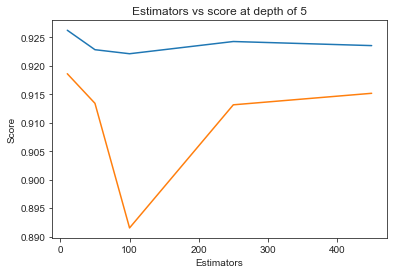

In [133]:
from sklearn.metrics import f1_score
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8677832982577944 test Score 0.8487895634454805
depth =  9 Train Score 0.9559338650544827 test Score 0.9162092003915061
depth =  11 Train Score 0.9612647738493958 test Score 0.9229629316002286
depth =  15 Train Score 0.9644194946654622 test Score 0.9123107194798529
depth =  20 Train Score 0.9638152545129289 test Score 0.9236111111111112
depth =  35 Train Score 0.9640806787583194 test Score 0.9236859374669236
depth =  50 Train Score 0.9640806787583194 test Score 0.9236859374669236
depth =  70 Train Score 0.9640806787583194 test Score 0.9236859374669236
depth =  130 Train Score 0.9640806787583194 test Score 0.9236859374669236


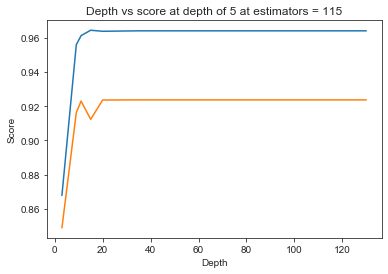

In [134]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [139]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=25),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000012C734AD748>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000012C734B8C88>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000012C734AD0C8>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000012C734ADA88>},
                   random_state=25, scoring='f1')

In [140]:
rf_random.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [141]:
print('mean test scores',rf_random.cv_results_['mean_test_score'])

mean test scores [0.96300155 0.96215403 0.96066941 0.96248903 0.96450457]


In [142]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [143]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [144]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [145]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9658791052652944
Test f1 score 0.9225060956217535


In [146]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


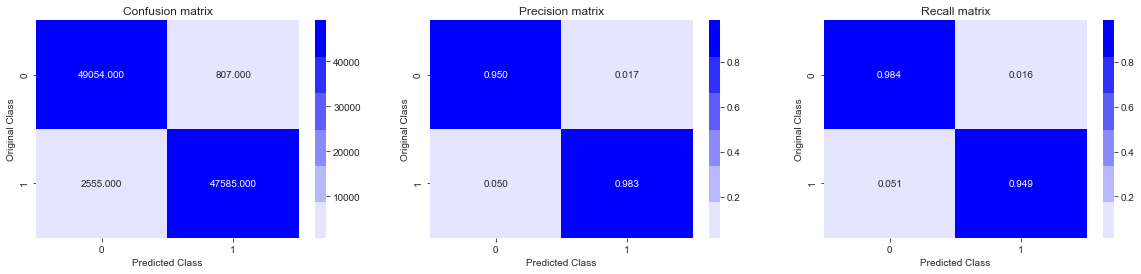

Test confusion_matrix


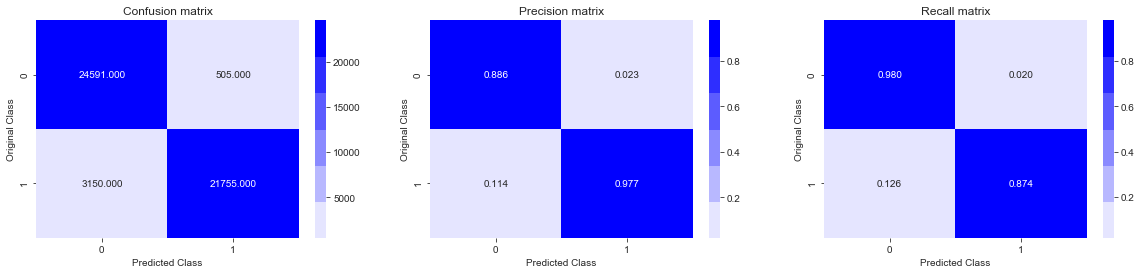

In [147]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

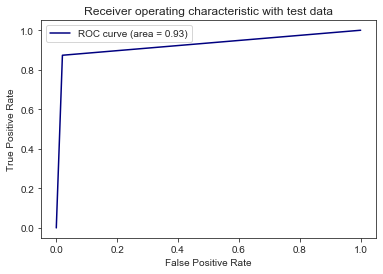

In [148]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

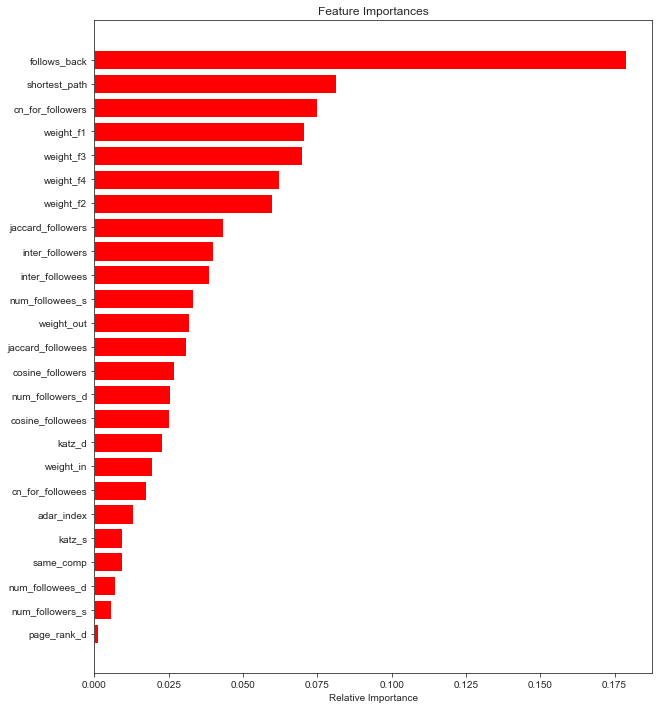

In [149]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Conclusion

In [151]:
from prettytable import PrettyTable
pretty=PrettyTable()
pretty.field_names=["max_depth","min_samples","n_estimators","train f1-score","test f1-score"]
pretty.add_row(["14","28","121","0.96","0.922"])
print(pretty)

+-----------+-------------+--------------+----------------+---------------+
| max_depth | min_samples | n_estimators | train f1-score | test f1-score |
+-----------+-------------+--------------+----------------+---------------+
|     14    |      28     |     121      |      0.96      |     0.922     |
+-----------+-------------+--------------+----------------+---------------+


**Steps**

1. Defining the problem statement business objections and the KPI

2. Importing necessary libraries

3. Reading and displaying a subgraph from the big- data to visulaize how a graph looks like

3. Exploratory Data Analysis id done and found out the for a particular user number of user following him is on an average 5 and the number of person's that user is following is also on an average 5. We also found the most of the followers and followees are less than 50 and there is a user total followers + followee in around **1579** rest all have number less than 100

4. To create a class label we need both 1's and 0's therefore we found missing link between users and sample only part of it and then classified it as 0 class label and the link present is classified as 1

5. Splitting is done in Train and Test randomly. After split we found that around **7%** of data in test set is not present in train data which could lead to a problem of cold start. 

6. Engineered Various features based on similarity measures like **Jaccard Index** , **cosine-similarity** etc, based on ranking measures link **page_rank** , **Kartz Centrality** etc some other graph based features include **Shortest_Path** we also created feautres related to **singluar value decompostion**  

7. Used **Boosting(XGBoost)** algorithm to train our model and calculated f1-score, because it is the metric to evaluate our model

8. We found that for the best parameter which we found through **randomizedsearchcv** f1- score for train is **96%** and that for test is **92%**